## Codon enrichment analysis for 30 RNA degradation factors


In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
import re
from scipy.optimize import curve_fit
import pybedtools 
from pybedtools.bedtool import BedTool
from collections import deque
from bisect import insort, bisect_left
from itertools import islice
from scipy.stats import gaussian_kde
import pickle
import seaborn as sns
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm

#### set these variables

In [3]:
home_dir = '/home/salma/Coding/cluster'

pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/codon_enrichment')

pathways_of_interest = ['NMD', 'Deadenylation', 'Decapping', 'Exosome', 'Xrn1']

In [4]:
#load data list
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary.txt'), header=None)
data_summary.columns=['factor', 'pathway', 'group']
data_summary.index = data_summary.factor

factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']
groups = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'group']
pathways = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'pathway']

lut = dict(zip(pathways.unique(), colors))
pw_colors = [lut[x] for x in pathways]

lut = dict(zip(pathways.unique(), colors))
pw_colors = [lut[x] for x in pathways]
g_names = pathways.unique()

In [5]:
# read coverage for expression level

coverage_path = os.path.join(home_dir, 'Annotations/salma/coverage_ohneUTR.bed')
coverage = pd.read_table(coverage_path, sep='\t', header= None)

coverage.columns = ['chr', 'start', 'end', 'type', 'strand', 's2', 's3', 'coverage']

coverage['length'] = coverage.end - coverage.start
coverage = coverage.loc[coverage.type.isin(['mRNA'])]

In [6]:
#build a matrix based on the Occupancies, previously calculated by cluster
# to see how it was built:
# /usr/users/ssohrab/CLIP/scripts/occupancy_allTranscripts_helper.py
# hint: it sums occupancies of xl sites falling into each transcript

occupancy = list()
for dir_occ in glob.glob(os.path.join(home_dir, 'data_analysis/co_occ_allTranscripts', '*.txt')):
    with open(dir_occ, 'r') as f:
        occupancy.append([float(i) for i in f.readlines()[0].split()])

factor_name = [os.path.basename(d).split('.')[0] for d in glob.glob(os.path.join\
                                    (home_dir, 'data_analysis/co_occ_allTranscripts', '*.txt'))]
factor_name = [s.split('_')[0] for s in factor_name]
factor_name = [s.split('-')[0] for s in factor_name]

occupancy = pd.DataFrame(occupancy).transpose()
occupancy.columns = factor_name

#filter mRNAs based on prior knowledge
occupancy = occupancy[1424:8001]

In [7]:
def fasta_parser(filename):
    with open(filename, 'r') as f:
        s = f.readlines()
    return list(map(str.rstrip, s[1::2]))

In [8]:
#estimate codon optimality for each transcript
opt_table = os.path.join(home_dir,'additional_files/codon_optimality_normalizedTE.txt')
#opt_table = os.path.join(home_dir,'additional_files/codon_optimality_classicalTE.txt')
codon_fromfile = pd.read_table(opt_table, comment='#', index_col=0)
optimality = codon_fromfile.to_dict()['Scer']
optimality['TAA'] = optimality['TAG'] = optimality['TGA'] =0 #stop codons

#### calculate codon frequencies of transcripts

In [9]:
#make fasta file for ORFs
# bedtools getfasta -s -fi ~/CLIP/Reference_genome/WholeGenomeFasta/genome.fa -bed 
# ~/CLIP/Annotations/R64-2-1_CDS.gff > ~/CLIP/additional_files/nonoverlap_ORFs.fa

if False:
    seqs = fasta_parser(os.path.join(home_dir, 'additional_files/nonoverlap_ORFs.fa'))

    codon_freqs = pd.DataFrame(index=range(len(seqs)), columns=list(optimality.keys()))
    codon_freqs = codon_freqs.fillna(0)

    for i, seq in enumerate(seqs):
        try:
            for j in range(0, len(seq), 3):
                codon_freqs.loc[i,seq[j:j+3]] += 1
        except:
            codon_freqs.loc[i,:] = 0

    codon_freqs = codon_freqs.div(codon_freqs.sum(axis=1), axis=0)

    CDs_df = pd.read_table(os.path.join(home_dir, 'Annotations/R64-2-1_CDS.gff'), header=None)
    CDs_df= CDs_df.join(codon_freqs)
    CDs_anno = BedTool.from_dataframe(CDs_df)

    coverage_bed = BedTool.from_dataframe(coverage)

    c = coverage_bed.intersect(CDs_anno, s=True, wao=True)


    mapped_df = c.to_dataframe(names = ['c' + str(i) for i in range(83)])

    mapped_df = mapped_df.drop_duplicates(subset=['c0', 'c1', 'c2'], keep='last', inplace=False)

    codons = list(optimality.keys())
    mapped_df.columns = list(mapped_df.columns[0:83-64-1]) + codons + ['overlap']

    print(len(mapped_df))
    print(len(coverage))

In [10]:
# Saving the objects:
#with open(os.path.join(home_dir, 'data_analysis', 'codon_counts.pkl'), 'wb') as f:
#    pickle.dump([mapped_df, coverage], f)

In [11]:
with open(os.path.join(home_dir, 'data_analysis', 'codon_counts2.pkl'), 'rb') as f:
    mapped_df, coverage = pickle.load(f)

#### assign colour to codons based on their optimality ranking

In [12]:
opt = pd.Series(optimality, name='optimality')
opt = opt.sort_values()
opt = pd.Series(np.arange(0,1,1/(len(opt))), index=opt.index)

colormap = matplotlib.cm.RdBu_r

codon_sorted = opt.index

binary=False
if(binary):
    non_optimal = codon_sorted[0:35]
    optimal = codon_sorted[35:]


    codon_col = {}
    for codon in non_optimal:
        codon_col[codon] = 'red'
    for codon in optimal:
        codon_col[codon] = 'green'    
else:
    codon_col = {}
    for i, codon in enumerate(opt.index):
        codon_col[codon] = colormap(opt[codon])

In [13]:
codons = list(optimality.keys())[:-3]
codondf = mapped_df.loc[:,codons]
bg_freq = {}
for codon in codons:
    bg_freq[codon] = sum(codondf.loc[~np.isnan(codondf.loc[:,codon]), codon])
    
bg=sum(bg_freq.values())
for codon in codons:
    bg_freq[codon] /= bg

In [14]:
sum(bg_freq.values())

0.9999999999999994

In [15]:
def is_not_outlier(data, m=2):
    return list(abs(data - np.mean(data)) < m * np.std(data))

In [16]:
def bootstrap(data):
    rows=np.random.randint(0, len(data.index), size=len(data.index))
    return data.iloc[rows,:]

In [17]:
def get_codon_enr(factor_df):
    fac_df = factor_df.copy()
    for i in range(len(fac_df.columns)-1):
        fac_df.iloc[:,i] = [a*b for a,b in zip(fac_df.iloc[:,i],fac_df.occupancy)]

    weighted_codon_freqs = fac_df.sum(axis=0)[0:len(fac_df.columns)-1]
    for codon in weighted_codon_freqs.index:
        weighted_codon_freqs[codon] /= (bg_freq[codon]*sum(fac_df.occupancy))
    return weighted_codon_freqs[codons]

In [18]:
def confidence_interval(data, confidence=90):
    l = (100-confidence)/2
    return np.percentile(data, l), np.percentile(data, 100-l)

In [19]:
occ_normed = occupancy.divide(coverage.length, axis=0)

#### plotting

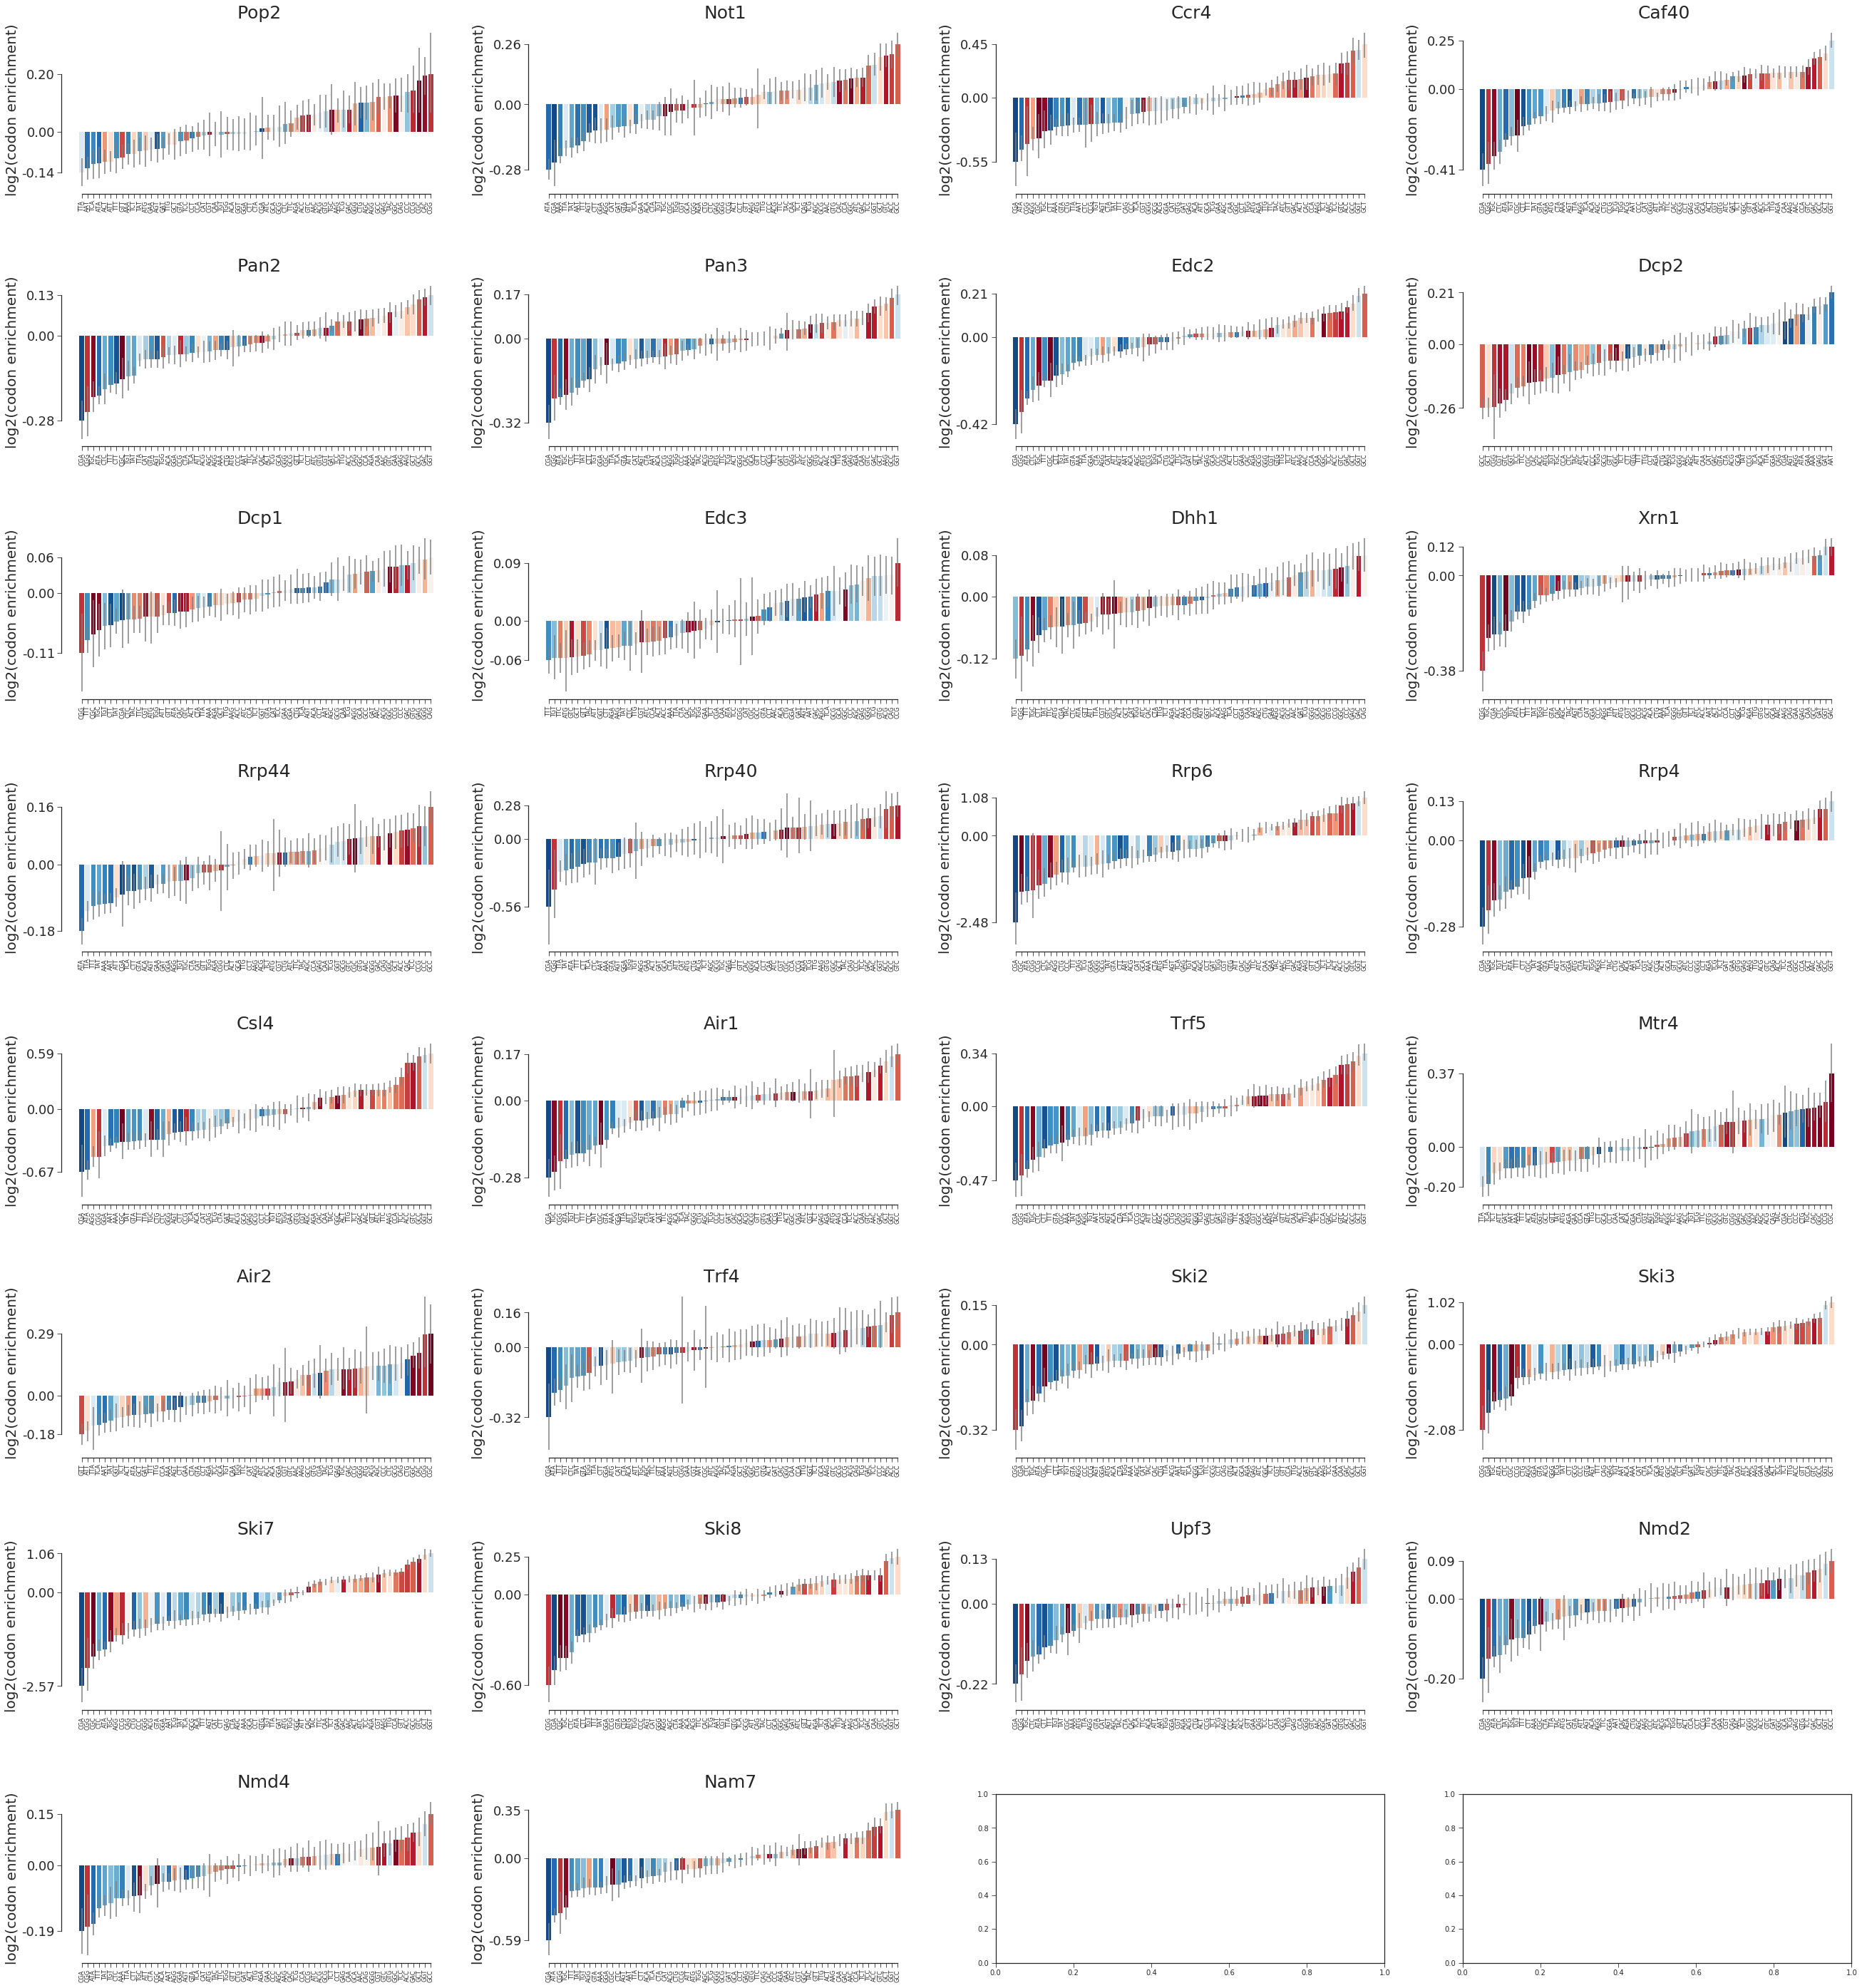

In [20]:
#supplementary figure: all in one

from matplotlib.ticker import FormatStrFormatter
sns.set_style("ticks")

wspace = 0.2
hspace = 0.5
nrows=8
ncols=4
f,axes = plt.subplots(nrows=8 ,ncols=4, figsize=(45,50))
plt.subplots_adjust(wspace=wspace, hspace=hspace)

for i, factor in enumerate(factors):
    np.random.seed(0)

    ax1 = axes[int(i/ncols)][int(i%ncols)]
    
    factor_df = mapped_df.loc[:,codons]
    factor_df['occupancy'] = list(occ_normed.loc[:,factor])
    factor_df=factor_df.dropna(axis=0)
    factor_df=factor_df.loc[is_not_outlier(factor_df.occupancy),:]

    weighted_codon_freqs = get_codon_enr(factor_df)

    bs_freqs=[]
    for i in range(1000):
        bs_table = bootstrap(factor_df)
        bs_freqs.append(get_codon_enr(bs_table))



    weighted_codon_freqs = weighted_codon_freqs.sort_values()
    yerr = [[],[]]
    for codon in weighted_codon_freqs.index:
        mn, mx = confidence_interval([x[codon] for x in bs_freqs])
        yerr[0].append(np.log2(mx)-np.log2(weighted_codon_freqs[codon]))
        yerr[1].append(np.log2(weighted_codon_freqs[codon])-np.log2(mn))

    x = np.arange(len(weighted_codon_freqs))
    barcolors = [codon_col[c] for c in weighted_codon_freqs.index]
    ax1.bar(x, np.log2(weighted_codon_freqs), color = barcolors, yerr=np.array(yerr), ecolor='grey', capsize=0)

    #ax1.set_xticklabels(weighted_codon_freqs.index, rotation=90, fontsize=8)
    plt.sca(ax1)
    xt = plt.xticks(x, weighted_codon_freqs.index, rotation=90, fontsize=8)
    ax1.spines['bottom'].set_bounds(0, 60)
    
    ax1.set_yticks([min(np.log2(weighted_codon_freqs)),0,max(np.log2(weighted_codon_freqs))])
    ax1.spines['left'].set_bounds(min(np.log2(weighted_codon_freqs)), max(np.log2(weighted_codon_freqs)))
    plt.yticks(fontsize=18)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ax1.text(0.45, 1.04, factor, transform=ax1.transAxes, fontsize=25)
    ax1.set_ylabel('log2(codon enrichment)', fontsize=20)
    
    
    
plt.savefig(os.path.join(plotting_dir, 'supplement.pdf'), bbox_inches='tight')